Vicenzino Matteo SM3201397

# Challenge 3: Artifical Neural Networks

<a target="_blank" href="https://colab.research.google.com/github/LucaPennella/Intro_to_ML_23-24/blob/main/challenges/challenge-three.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


Using Fully Connected Neural Networks and Convolutional Neural Networks, perform the following tasks on [KMNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.KMNIST.html#torchvision.datasets.KMNIST).
1. Data exploration.
    * Provide a grid plot of the first 10/12 examples with associated labels
    * Split using the provided pytorch objects into train/validation/test sets
2. For each architecture, tune the number of the hidden layers ($\le 3$), the optimizer, and some hyperparameters of your choice. How many tries to do is up to your discretion. Discuss the choice you made in the report.
3. Summarise your results in a table and comment on them in the report.
4. For a model (not necessarily the best performing one), plot training loss vs testing loss and training accuracy vs testing accuracy, and comment on what you see.
    * Beyond accuracy provide the confusion matrix for the model outputs. Discuss differences between train/validation/test sets. Is accuracy a good metric in this case why or why not?

In [6]:
import torch
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
torch.manual_seed(0)

import matplotlib.pyplot as plt
import time

Load the dataset

In [2]:
BATCH_SIZE = 64
data_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

full_train = torchvision.datasets.KMNIST(root="./data", train=True,  transform=data_transforms, download=True)
full_train_loader = torch.utils.data.DataLoader(full_train, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 18.2M/18.2M [00:08<00:00, 2.06MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 375kB/s]
100%|██████████| 3.04M/3.04M [00:01<00:00, 2.25MB/s]
100%|██████████| 5.12k/5.12k [00:00<00:00, 11.4MB/s]


## 1. Data exploration

Plot 10 images from the train set, with the corresponding label

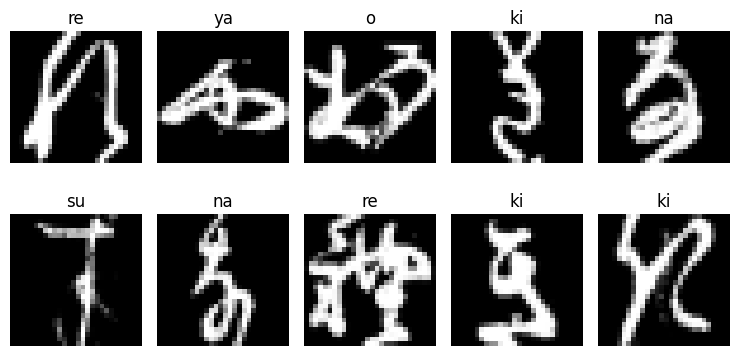

Number of different labels in the training set:  10


In [3]:
num_row = 2
num_col = 5

classes = full_train.classes

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col, 2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(full_train.data[i], cmap='gray')
    ax.axis('off')
    ax.set_title('{}'.format(classes[full_train.targets[i]]))
plt.tight_layout()
plt.show()

num_classes = len(full_train.classes)
print("Number of different labels in the training set: ", num_classes)


In [4]:
print("Single image dimensions:",full_train.data[0].shape)
for images, labels in full_train_loader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Single image dimensions: torch.Size([28, 28])
Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])


Divide **train** and **validation**, load **test set**

In [5]:
trainset, valset = random_split(full_train, [int(len(full_train) * 0.8), int(len(full_train) * 0.2)])
testset = torchvision.datasets.KMNIST(root="./data", train=False, transform=data_transforms, download=True)

# augmentation
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])
trainset.dataset.transform = train_transform


trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training set size: {len(trainset)} samples")
print(f"Validation set size: {len(valset)} samples")
print(f"Test set size: {len(testset)} samples")

Training set size: 48000 samples
Validation set size: 12000 samples
Test set size: 10000 samples


## 2. NN design exploration

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import SGD

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


##### Useful functions to run multiples models quickly

In [7]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train the model for one epoch

    Args:
        model: PyTorch model
        dataloader: Training data loader
        criterion: Loss function
        optimizer: Optimizer for the model
        device: Device to run the model on (cpu/cuda)

    Returns:
        average_loss: Average loss over the epoch
        accuracy: Training accuracy
    """

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    average_loss = running_loss / total
    accuracy = 100 * correct / total

    return average_loss, accuracy

In [8]:
def evaluate(model, dataloader, criterion, device):
    """
    Evaluate the model on the given dataloader

    Args:
        model: PyTorch model
        dataloader: Validation/Test data loader
        criterion: Loss function
        device: Device to run the model on (cpu/cuda)

    Returns:
        average_loss: Average loss
        accuracy: Evaluation accuracy
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    average_loss = running_loss / total
    accuracy = 100 * correct / total

    return average_loss, accuracy

In [9]:
def train_model(model, trainloader, valloader, testloader, device,
             criterion=None, optimizer=None, num_epochs=10,
             lr=0.001, plot_results=True):
    """
    Train a model and evaluate on validation and test sets

    Args:
        model: PyTorch model to train
        trainloader: DataLoader for training data
        valloader: DataLoader for validation data
        testloader: DataLoader for test data
        criterion: Loss function (default: CrossEntropyLoss)
        optimizer: Optimizer (default: Adam)
        num_epochs: Number of training epochs
        device: Device to run on (default: will use CUDA if available)
        lr: Learning rate if using default optimizer
        plot_results: Whether to plot training curves

    Returns:
        model: Trained model
        history: Dictionary containing training history
    """

    # Move model to device
    model = model.to(device)

    # Set default criterion if not provided
    if criterion is None:
        criterion = nn.CrossEntropyLoss()

    # Set default optimizer if not provided
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=lr)

    # To store training history
    history = {
        'train_losses': [],
        'train_accuracies': [],
        'val_losses': [],
        'val_accuracies': [],
    }

    # Training loop
    start_time = time.time()

    for epoch in range(num_epochs):
        # Train for one epoch
        train_loss, train_accuracy = train_epoch(model, trainloader, criterion, optimizer, device)
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_accuracy)

        # Evaluate on validation set
        val_loss, val_accuracy = evaluate(model, valloader, criterion, device)
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_accuracy)

        # Print epoch statistics
        print(f" Epoch {epoch+1:2}  |  "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Acc: {train_accuracy:.2f}%  |  "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Acc: {val_accuracy:.2f}%")


    # Calculate total training time
    total_time = time.time() - start_time
    print(f"Training completed in {total_time:.2f} seconds\n")

    # Evaluate on test set
    test_loss, test_accuracy = evaluate(model, testloader, criterion, device)
    print(f"TEST SET Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")

    # Add test results to history
    history['test_loss'] = test_loss
    history['test_accuracy'] = test_accuracy

    # Plot training and validation metrics
    if plot_results:
        plt.figure(figsize=(12, 5))

        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(range(1, num_epochs+1), history['train_losses'], 'b-', label='Training Loss')
        plt.plot(range(1, num_epochs+1), history['val_losses'], 'r-', label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(range(1, num_epochs+1), history['train_accuracies'], 'b-', label='Training Accuracy')
        plt.plot(range(1, num_epochs+1), history['val_accuracies'], 'r-', label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

        def get_predictions(model, dataloader, device):
            model.eval()
            y_true = []
            y_pred = []
            with torch.no_grad():
                for images, labels in dataloader:
                    images = images.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs, 1)
                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(predicted.cpu().numpy())
            return y_true, y_pred

        preds = {
            'train': get_predictions(model, trainloader, device),
            'val': get_predictions(model, valloader, device),
            'test': get_predictions(model, testloader, device),
        }



    return model, history, preds

### Fully Connected NN Architecture

In [10]:
# 2 hidden layers

class FCNN2(nn.Module):
    def __init__(self, input_size=28*28, h1=256, h2=256, num_classes=10, dropout_rate=0.5):
        super(FCNN2, self).__init__()
        self.fc1 = nn.Linear(input_size, h1)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(h1, h2)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.out = nn.Linear(h2, num_classes)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.out(x)
        return x

 Epoch  1  |  Train Loss: 0.9612, Train Acc: 69.02%  |  Val Loss: 0.5057, Val Acc: 84.09%
 Epoch  2  |  Train Loss: 0.5314, Train Acc: 83.31%  |  Val Loss: 0.3947, Val Acc: 87.71%
 Epoch  3  |  Train Loss: 0.4291, Train Acc: 86.62%  |  Val Loss: 0.3238, Val Acc: 90.08%
 Epoch  4  |  Train Loss: 0.3696, Train Acc: 88.71%  |  Val Loss: 0.2879, Val Acc: 91.17%
 Epoch  5  |  Train Loss: 0.3328, Train Acc: 89.76%  |  Val Loss: 0.2550, Val Acc: 92.32%
 Epoch  6  |  Train Loss: 0.3019, Train Acc: 90.83%  |  Val Loss: 0.2418, Val Acc: 92.71%
 Epoch  7  |  Train Loss: 0.2815, Train Acc: 91.31%  |  Val Loss: 0.2307, Val Acc: 92.92%
 Epoch  8  |  Train Loss: 0.2648, Train Acc: 91.82%  |  Val Loss: 0.2161, Val Acc: 93.42%
 Epoch  9  |  Train Loss: 0.2512, Train Acc: 92.28%  |  Val Loss: 0.2062, Val Acc: 93.97%
 Epoch 10  |  Train Loss: 0.2382, Train Acc: 92.60%  |  Val Loss: 0.1979, Val Acc: 94.06%
Training completed in 172.80 seconds

TEST SET Loss: 0.3906, Accuracy: 88.31%


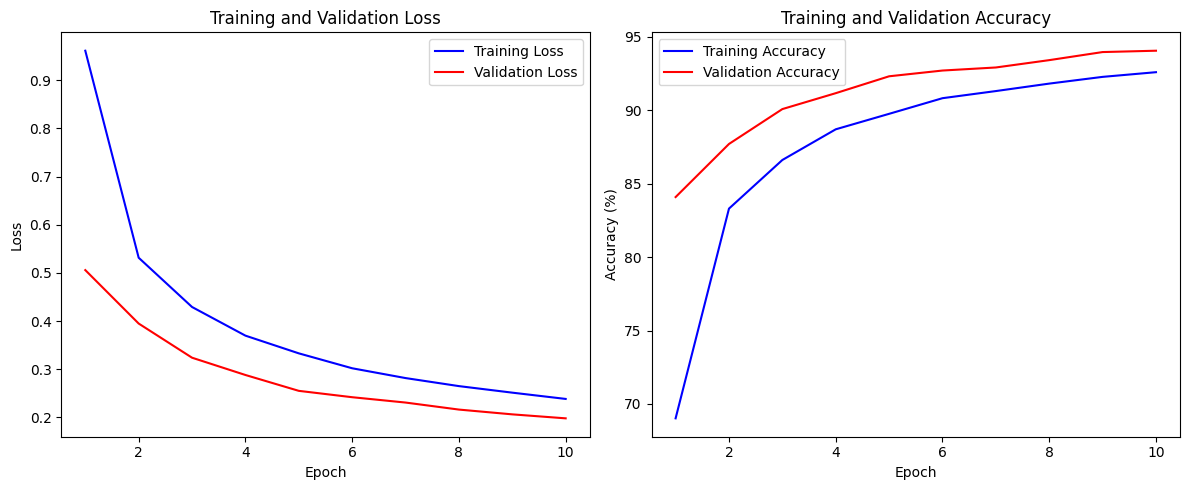

In [11]:
model_1 = FCNN2(dropout_rate=0.3)

trained_model_1, history_model_1, predictions_model_1 = train_model(
    model=model_1,
    trainloader=trainloader,
    valloader=valloader,
    testloader=testloader,
    device=device,
    optimizer=SGD(model_1.parameters(), lr=0.005, momentum=0.9)
    )

In [12]:
# 3 hidden layers

class FCNN3(nn.Module):
    def __init__(self, input_size=28*28, h1=512, h2=256, h3=64, num_classes=10, dropout_rate=0.2):
        super(FCNN3, self).__init__()
        self.fc1 = nn.Linear(input_size, h1)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(h1, h2)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.fc3 = nn.Linear(h2, h3)
        self.dropout3 = nn.Dropout(p=dropout_rate)
        self.out = nn.Linear(h3, num_classes)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.out(x)
        return x


 Epoch  1  |  Train Loss: 0.9104, Train Acc: 70.18%  |  Val Loss: 0.4412, Val Acc: 86.45%
 Epoch  2  |  Train Loss: 0.4443, Train Acc: 86.37%  |  Val Loss: 0.3168, Val Acc: 89.93%
 Epoch  3  |  Train Loss: 0.3411, Train Acc: 89.60%  |  Val Loss: 0.2622, Val Acc: 92.01%
 Epoch  4  |  Train Loss: 0.2887, Train Acc: 91.16%  |  Val Loss: 0.2378, Val Acc: 92.78%
 Epoch  5  |  Train Loss: 0.2562, Train Acc: 92.06%  |  Val Loss: 0.2613, Val Acc: 91.92%
 Epoch  6  |  Train Loss: 0.2301, Train Acc: 92.98%  |  Val Loss: 0.2270, Val Acc: 93.08%
 Epoch  7  |  Train Loss: 0.2017, Train Acc: 93.93%  |  Val Loss: 0.1857, Val Acc: 94.49%
 Epoch  8  |  Train Loss: 0.1894, Train Acc: 94.15%  |  Val Loss: 0.1789, Val Acc: 94.51%
 Epoch  9  |  Train Loss: 0.1744, Train Acc: 94.70%  |  Val Loss: 0.1780, Val Acc: 94.73%
 Epoch 10  |  Train Loss: 0.1635, Train Acc: 94.97%  |  Val Loss: 0.1750, Val Acc: 94.84%
Training completed in 171.63 seconds

TEST SET Loss: 0.3585, Accuracy: 89.46%


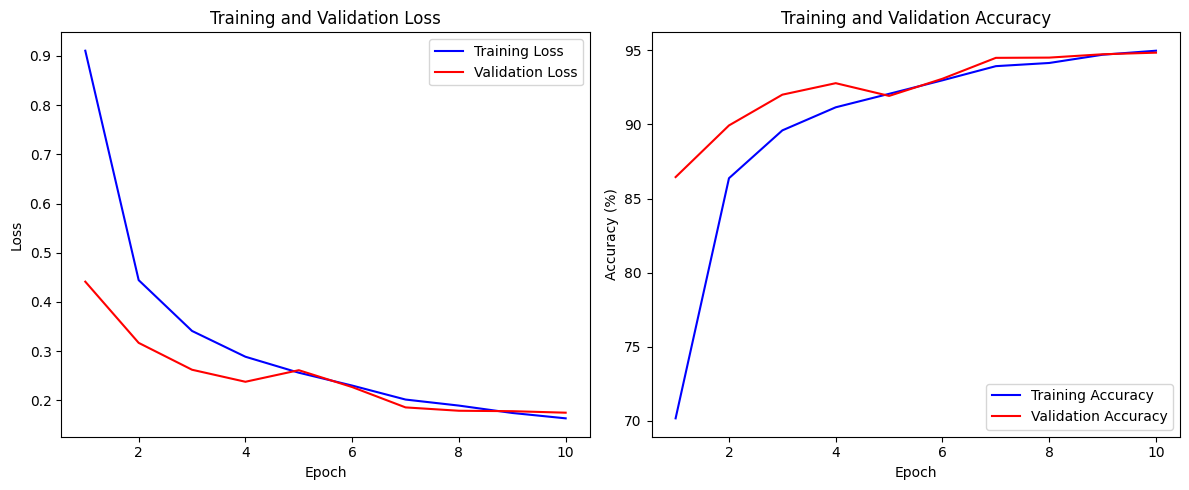

In [13]:
model_2 = FCNN3(dropout_rate=0.2)

trained_model_2, history_model_2, predictions_model_2 = train_model(
    model=model_2,
    trainloader=trainloader,
    valloader=valloader,
    testloader=testloader,
    device=device,
    optimizer=SGD(model_2.parameters(), lr=0.01, momentum=0.9)
    )

 Epoch  1  |  Train Loss: 0.8124, Train Acc: 73.42%  |  Val Loss: 0.4146, Val Acc: 86.89%
 Epoch  2  |  Train Loss: 0.4638, Train Acc: 85.73%  |  Val Loss: 0.3187, Val Acc: 90.13%
 Epoch  3  |  Train Loss: 0.3822, Train Acc: 88.33%  |  Val Loss: 0.2643, Val Acc: 91.72%
 Epoch  4  |  Train Loss: 0.3391, Train Acc: 89.66%  |  Val Loss: 0.2388, Val Acc: 92.97%
 Epoch  5  |  Train Loss: 0.3049, Train Acc: 90.72%  |  Val Loss: 0.2269, Val Acc: 93.29%
 Epoch  6  |  Train Loss: 0.2852, Train Acc: 91.18%  |  Val Loss: 0.2077, Val Acc: 93.95%
 Epoch  7  |  Train Loss: 0.2659, Train Acc: 91.85%  |  Val Loss: 0.1997, Val Acc: 94.12%
 Epoch  8  |  Train Loss: 0.2545, Train Acc: 92.30%  |  Val Loss: 0.1884, Val Acc: 94.50%
 Epoch  9  |  Train Loss: 0.2410, Train Acc: 92.44%  |  Val Loss: 0.1865, Val Acc: 94.37%
 Epoch 10  |  Train Loss: 0.2312, Train Acc: 92.76%  |  Val Loss: 0.1725, Val Acc: 94.82%
Training completed in 173.07 seconds

TEST SET Loss: 0.3756, Accuracy: 88.81%


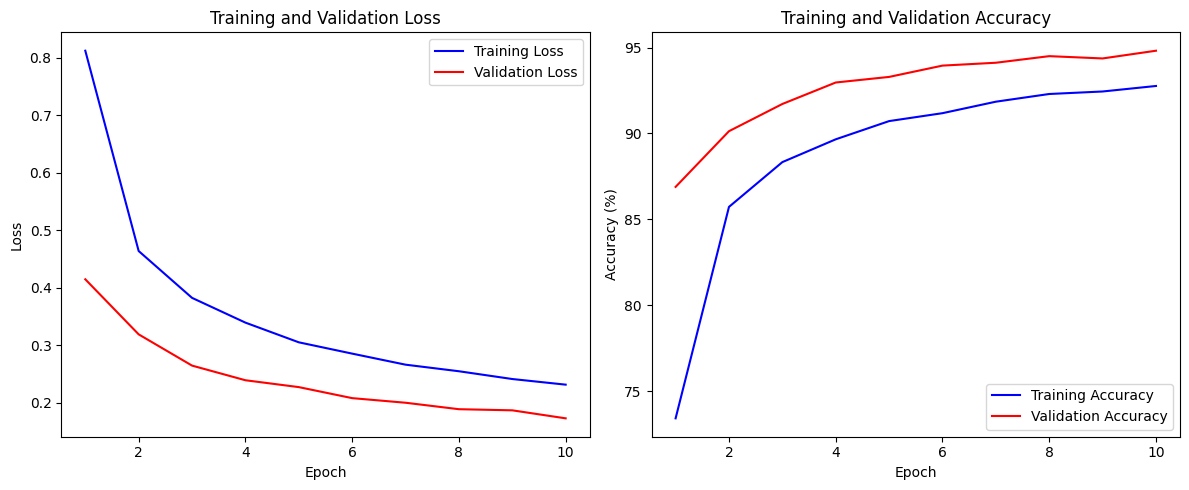

In [14]:
model_3 = FCNN3(h1=512, h2=256, h3=256, dropout_rate=0.4)

trained_model_3, history_model_3, predictions_model_3  = train_model(
    model=model_3,
    trainloader=trainloader,
    valloader=valloader,
    testloader=testloader,
    device=device,
    lr=0.0005
    )

### Convolutional NN Architecture

In [15]:
class CNN2(nn.Module):
    def __init__(self, h1=32, h2=64, use_batchnorm=True, dropout_rate=0.5):
        super(CNN2, self).__init__()
        self.use_batchnorm = use_batchnorm

        # First convolutional block
        self.conv1 = nn.Conv2d(1, h1, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        if use_batchnorm:
            self.bn1 = nn.BatchNorm2d(h1)

        # Second convolutional block
        self.conv2 = nn.Conv2d(h1, h2, kernel_size=3, stride=1, padding=1)
        if use_batchnorm:
            self.bn2 = nn.BatchNorm2d(h2)

        # Calculate the size after pooling twice
        # For 28x28 input: 28/2/2 = 7
        feature_size = 7 * 7 * h2

        # Fully connected layers
        self.fc1 = nn.Linear(feature_size, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        # First block
        x = self.conv1(x)
        if self.use_batchnorm:
            x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)

        # Second block
        x = self.conv2(x)
        if self.use_batchnorm:
            x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)

        # Flatten and fully connected layers
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

 Epoch  1  |  Train Loss: 0.9948, Train Acc: 64.50%  |  Val Loss: 0.2944, Val Acc: 91.67%
 Epoch  2  |  Train Loss: 0.5437, Train Acc: 81.08%  |  Val Loss: 0.1850, Val Acc: 94.58%
 Epoch  3  |  Train Loss: 0.4134, Train Acc: 85.92%  |  Val Loss: 0.1395, Val Acc: 95.84%
 Epoch  4  |  Train Loss: 0.3376, Train Acc: 88.71%  |  Val Loss: 0.1118, Val Acc: 96.72%
 Epoch  5  |  Train Loss: 0.2787, Train Acc: 90.74%  |  Val Loss: 0.1009, Val Acc: 96.95%
 Epoch  6  |  Train Loss: 0.2362, Train Acc: 92.40%  |  Val Loss: 0.1008, Val Acc: 97.01%
 Epoch  7  |  Train Loss: 0.2178, Train Acc: 92.97%  |  Val Loss: 0.0963, Val Acc: 97.23%
 Epoch  8  |  Train Loss: 0.2031, Train Acc: 93.29%  |  Val Loss: 0.0906, Val Acc: 97.43%
 Epoch  9  |  Train Loss: 0.1890, Train Acc: 93.95%  |  Val Loss: 0.0854, Val Acc: 97.47%
 Epoch 10  |  Train Loss: 0.1802, Train Acc: 94.13%  |  Val Loss: 0.0851, Val Acc: 97.58%
Training completed in 184.39 seconds

TEST SET Loss: 0.2503, Accuracy: 93.77%


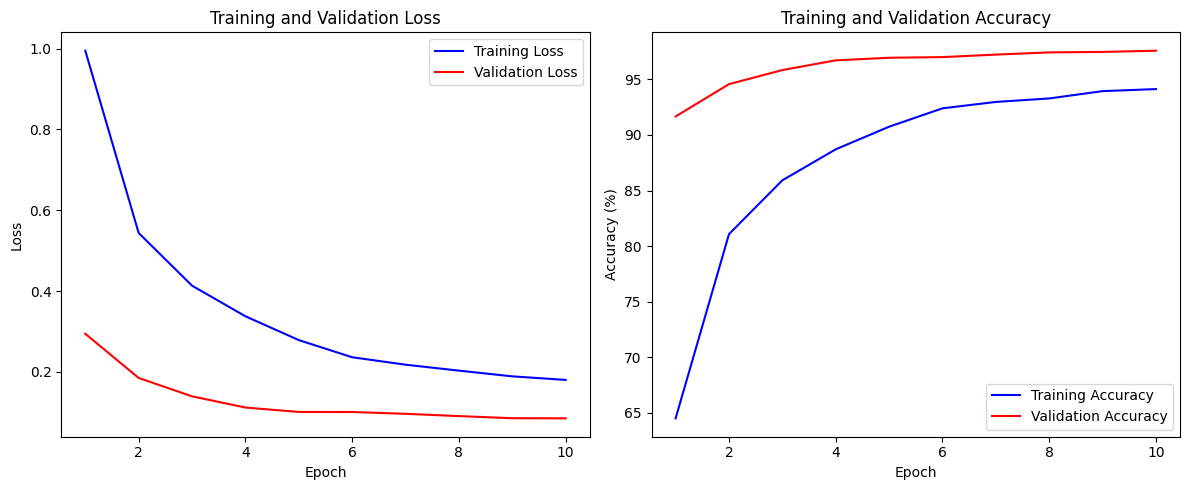

In [16]:
CNN2_model_1 = CNN2()

trained_CNN2_model_1, CNN2_model_1_history, CNN2_model_1_predictions = train_model(
    model=CNN2_model_1,
    trainloader=trainloader,
    valloader=valloader,
    testloader=testloader,
    device=device,
    lr = 0.005
    )

 Epoch  1  |  Train Loss: 0.6440, Train Acc: 78.79%  |  Val Loss: 0.2319, Val Acc: 92.78%
 Epoch  2  |  Train Loss: 0.3652, Train Acc: 88.12%  |  Val Loss: 0.1581, Val Acc: 95.16%
 Epoch  3  |  Train Loss: 0.2858, Train Acc: 90.94%  |  Val Loss: 0.1279, Val Acc: 95.93%
 Epoch  4  |  Train Loss: 0.2403, Train Acc: 92.24%  |  Val Loss: 0.1091, Val Acc: 96.60%
 Epoch  5  |  Train Loss: 0.2096, Train Acc: 93.22%  |  Val Loss: 0.0991, Val Acc: 97.05%
 Epoch  6  |  Train Loss: 0.1820, Train Acc: 94.00%  |  Val Loss: 0.1026, Val Acc: 96.91%
 Epoch  7  |  Train Loss: 0.1650, Train Acc: 94.60%  |  Val Loss: 0.0856, Val Acc: 97.36%
 Epoch  8  |  Train Loss: 0.1507, Train Acc: 95.18%  |  Val Loss: 0.0748, Val Acc: 97.80%
 Epoch  9  |  Train Loss: 0.1403, Train Acc: 95.52%  |  Val Loss: 0.0811, Val Acc: 97.66%
 Epoch 10  |  Train Loss: 0.1253, Train Acc: 95.86%  |  Val Loss: 0.0764, Val Acc: 97.72%
Training completed in 202.28 seconds

TEST SET Loss: 0.2082, Accuracy: 94.56%


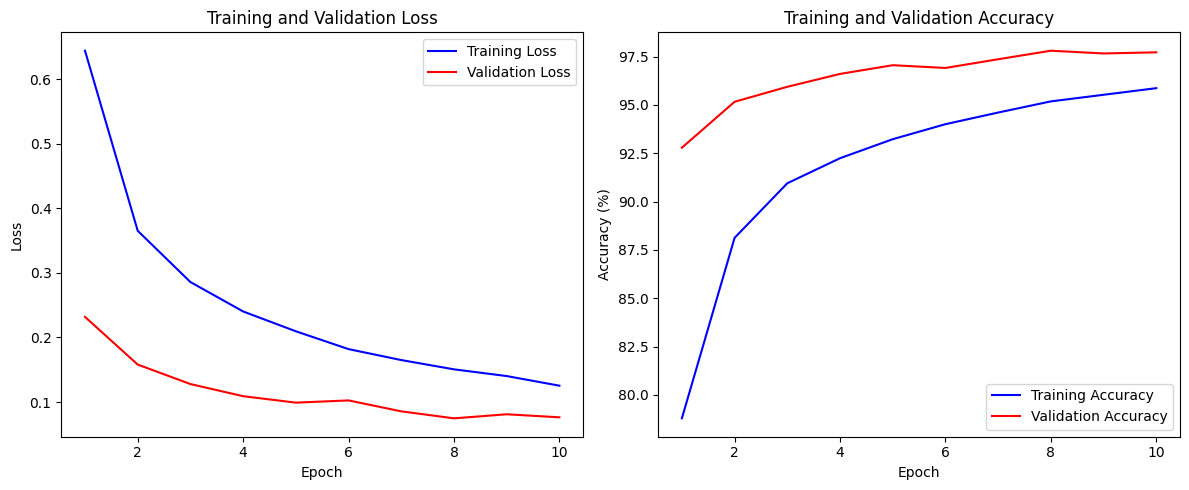

In [17]:
CNN2_model_2 = CNN2(h1=64, h2=128, use_batchnorm=True, dropout_rate=0.5)

trained_CNN2_model_2, CNN2_model_2_history, CNN2_model_2_predictions = train_model(
    model=CNN2_model_2,
    trainloader=trainloader,
    valloader=valloader,
    testloader=testloader,
    device=device,
    optimizer=SGD(CNN2_model_2.parameters(), lr=0.01, momentum=0.9)
    )

In [18]:
class CNN3(nn.Module):
    def __init__(self, h1=32, h2=64, h3=128, use_batchnorm=True, dropout_rate=0.5):
        super(CNN3, self).__init__()
        self.use_batchnorm = use_batchnorm

        # First convolutional block
        self.conv1 = nn.Conv2d(1, h1, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        if use_batchnorm:
            self.bn1 = nn.BatchNorm2d(h1)

        # Second convolutional block
        self.conv2 = nn.Conv2d(h1, h2, kernel_size=3, stride=1, padding=1)
        if use_batchnorm:
            self.bn2 = nn.BatchNorm2d(h2)

        # Third convolutional block
        self.conv3 = nn.Conv2d(h2, h3, kernel_size=3, stride=1, padding=1)
        if use_batchnorm:
            self.bn3 = nn.BatchNorm2d(h3)

        # Calculate the size after pooling three times
        # For 28x28 input: 28/2/2/2 = 3.5 -> 3
        feature_size = 3 * 3 * h3

        # Fully connected layers
        self.fc1 = nn.Linear(feature_size, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        # First block
        x = self.conv1(x)
        if self.use_batchnorm:
            x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)

        # Second block
        x = self.conv2(x)
        if self.use_batchnorm:
            x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)

        # Third block
        x = self.conv3(x)
        if self.use_batchnorm:
            x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)

        # Flatten and fully connected layers
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

 Epoch  1  |  Train Loss: 0.4531, Train Acc: 85.69%  |  Val Loss: 0.1470, Val Acc: 95.53%
 Epoch  2  |  Train Loss: 0.1739, Train Acc: 94.72%  |  Val Loss: 0.0926, Val Acc: 97.17%
 Epoch  3  |  Train Loss: 0.1243, Train Acc: 96.33%  |  Val Loss: 0.0744, Val Acc: 97.74%
 Epoch  4  |  Train Loss: 0.1000, Train Acc: 96.99%  |  Val Loss: 0.0720, Val Acc: 97.77%
 Epoch  5  |  Train Loss: 0.0803, Train Acc: 97.61%  |  Val Loss: 0.0590, Val Acc: 98.28%
 Epoch  6  |  Train Loss: 0.0728, Train Acc: 97.81%  |  Val Loss: 0.0611, Val Acc: 98.17%
 Epoch  7  |  Train Loss: 0.0608, Train Acc: 98.22%  |  Val Loss: 0.0563, Val Acc: 98.25%
 Epoch  8  |  Train Loss: 0.0535, Train Acc: 98.34%  |  Val Loss: 0.0470, Val Acc: 98.62%
 Epoch  9  |  Train Loss: 0.0482, Train Acc: 98.52%  |  Val Loss: 0.0530, Val Acc: 98.39%
 Epoch 10  |  Train Loss: 0.0451, Train Acc: 98.65%  |  Val Loss: 0.0548, Val Acc: 98.50%
Training completed in 218.59 seconds

TEST SET Loss: 0.1779, Accuracy: 95.41%


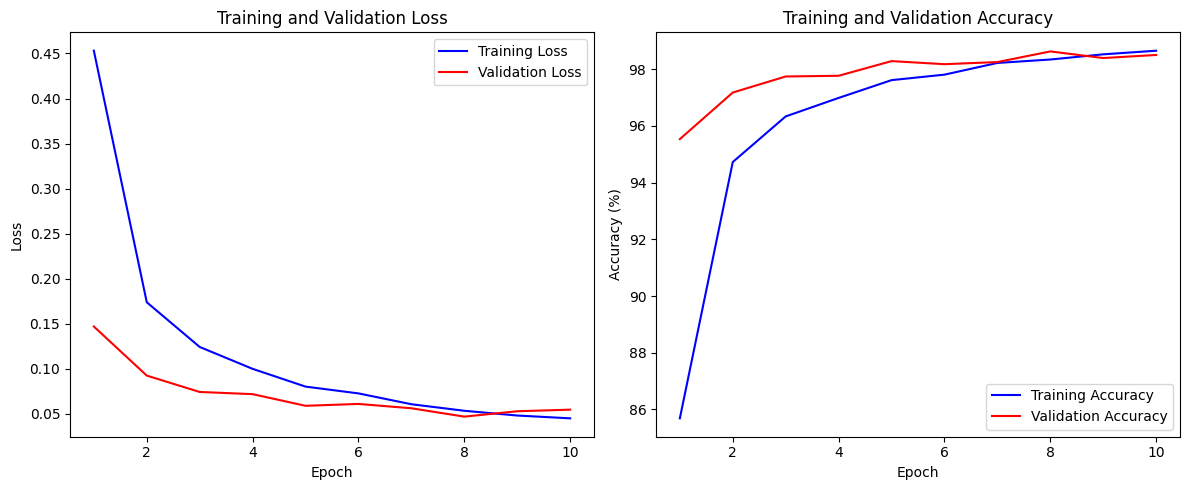

In [19]:
# Configuration 4: SGD with larger hidden units
CNN3_model_4 = CNN3(h1=64, h2=128, h3=256, use_batchnorm=True, dropout_rate=0.5)

trained_CNN3_model_4, CNN3_model_4_history, CNN3_model_4_predictions = train_model(
    model=CNN3_model_4,
    trainloader=trainloader,
    valloader=valloader,
    testloader=testloader,
    device=device,
    optimizer=torch.optim.SGD(CNN3_model_4.parameters(), lr=0.005, momentum=0.9),
    lr=0.005
    )

 Epoch  1  |  Train Loss: 0.4218, Train Acc: 86.90%  |  Val Loss: 0.1229, Val Acc: 96.21%
 Epoch  2  |  Train Loss: 0.1728, Train Acc: 94.88%  |  Val Loss: 0.0882, Val Acc: 97.14%
 Epoch  3  |  Train Loss: 0.1300, Train Acc: 96.22%  |  Val Loss: 0.0788, Val Acc: 97.66%
 Epoch  4  |  Train Loss: 0.1049, Train Acc: 96.92%  |  Val Loss: 0.0833, Val Acc: 97.50%
 Epoch  5  |  Train Loss: 0.0890, Train Acc: 97.31%  |  Val Loss: 0.0717, Val Acc: 97.72%
 Epoch  6  |  Train Loss: 0.0760, Train Acc: 97.69%  |  Val Loss: 0.0598, Val Acc: 98.43%
 Epoch  7  |  Train Loss: 0.0685, Train Acc: 97.94%  |  Val Loss: 0.0531, Val Acc: 98.37%
 Epoch  8  |  Train Loss: 0.0612, Train Acc: 98.10%  |  Val Loss: 0.0529, Val Acc: 98.47%
 Epoch  9  |  Train Loss: 0.0573, Train Acc: 98.18%  |  Val Loss: 0.0537, Val Acc: 98.42%
 Epoch 10  |  Train Loss: 0.0504, Train Acc: 98.42%  |  Val Loss: 0.0486, Val Acc: 98.62%
Training completed in 198.80 seconds

TEST SET Loss: 0.1563, Accuracy: 96.03%


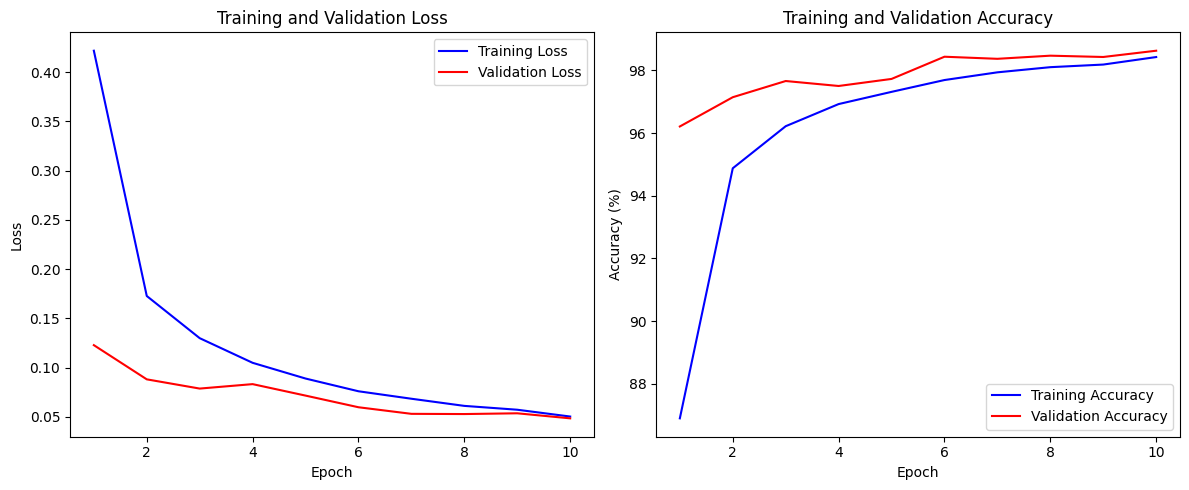

In [20]:
# Configuration 5: RMSprop with pyramid architecture (expanding)
CNN3_model_5 = CNN3(h1=32, h2=64, h3=128, use_batchnorm=True, dropout_rate=0.5)

trained_CNN3_model_5, CNN3_model_5_history, CNN3_model_5_predictions = train_model(
    model=CNN3_model_5,
    trainloader=trainloader,
    valloader=valloader,
    testloader=testloader,
    device=device,
    lr=0.001
    )

 Epoch  1  |  Train Loss: 0.3759, Train Acc: 88.06%  |  Val Loss: 0.1434, Val Acc: 95.47%
 Epoch  2  |  Train Loss: 0.1641, Train Acc: 95.01%  |  Val Loss: 0.0892, Val Acc: 97.37%
 Epoch  3  |  Train Loss: 0.1252, Train Acc: 96.14%  |  Val Loss: 0.0839, Val Acc: 97.57%
 Epoch  4  |  Train Loss: 0.1126, Train Acc: 96.69%  |  Val Loss: 0.0650, Val Acc: 97.99%
 Epoch  5  |  Train Loss: 0.1017, Train Acc: 96.91%  |  Val Loss: 0.0800, Val Acc: 97.61%
 Epoch  6  |  Train Loss: 0.0898, Train Acc: 97.20%  |  Val Loss: 0.0732, Val Acc: 97.86%
 Epoch  7  |  Train Loss: 0.0858, Train Acc: 97.36%  |  Val Loss: 0.0641, Val Acc: 98.17%
 Epoch  8  |  Train Loss: 0.0818, Train Acc: 97.49%  |  Val Loss: 0.0702, Val Acc: 98.04%
 Epoch  9  |  Train Loss: 0.0771, Train Acc: 97.61%  |  Val Loss: 0.0686, Val Acc: 98.14%
 Epoch 10  |  Train Loss: 0.0731, Train Acc: 97.75%  |  Val Loss: 0.0572, Val Acc: 98.47%
Training completed in 191.71 seconds

TEST SET Loss: 0.1781, Accuracy: 95.75%


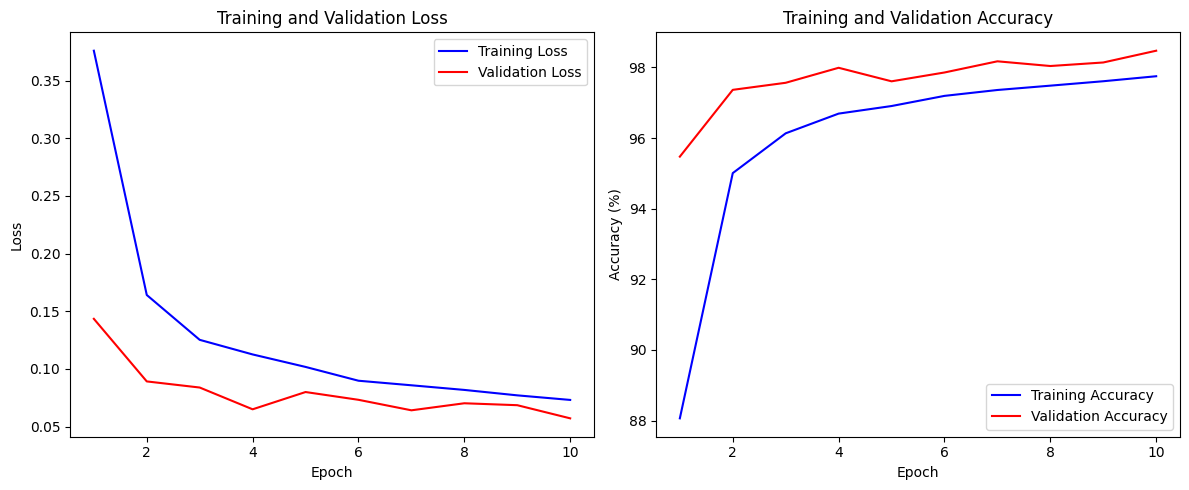

In [22]:
# Configuration 7: SGD with smaller model size
CNN3_model_7 = CNN3(h1=16, h2=32, h3=64, use_batchnorm=True, dropout_rate=0.4)

trained_CNN3_model_7, CNN3_model_7_history, CNN3_model_7_predictions = train_model(
    model=CNN3_model_7,
    trainloader=trainloader,
    valloader=valloader,
    testloader=testloader,
    device=device,
    lr=0.005
    )

## 3. Results

In [23]:
from tabulate import tabulate

tab_models = [
    {
        "Model": "FCNN",
        "Hidden Layers": 2,
        "Hidden Layers Size": "256, 256",
        "Learning Rate": 0.005,
        "Optimiser": "SGD",
        "Dropout Rate": 0.3,
        "Train Accuracy": history_model_1['train_accuracies'][-1],
        "Validation Accuracy": history_model_1['val_accuracies'][-1],
        "Test Accuracy": history_model_1['test_accuracy']
    },
    {
        "Model": "FCNN",
        "Hidden Layers": 3,
        "Hidden Layers Size": "512, 256, 64",
        "Learning Rate": 0.01,
        "Optimiser": "SGD",
        "Dropout Rate": 0.2,
        "Train Accuracy": history_model_2['train_accuracies'][-1],
        "Validation Accuracy": history_model_2['val_accuracies'][-1],
        "Test Accuracy": history_model_2['test_accuracy']
    },
    {
        "Model": "FCNN",
        "Hidden Layers": 3,
        "Hidden Layers Size": "512, 256, 256",
        "Learning Rate": 0.0005,
        "Optimiser": "Adam",
        "Dropout Rate": 0.4,
        "Train Accuracy": history_model_3['train_accuracies'][-1],
        "Validation Accuracy": history_model_3['val_accuracies'][-1],
        "Test Accuracy": history_model_3['test_accuracy']
    }
]

print(tabulate(tab_models, headers="keys", tablefmt="rounded_outline"))

╭─────────┬─────────────────┬──────────────────────┬─────────────────┬─────────────┬────────────────┬──────────────────┬───────────────────────┬─────────────────╮
│ Model   │   Hidden Layers │ Hidden Layers Size   │   Learning Rate │ Optimiser   │   Dropout Rate │   Train Accuracy │   Validation Accuracy │   Test Accuracy │
├─────────┼─────────────────┼──────────────────────┼─────────────────┼─────────────┼────────────────┼──────────────────┼───────────────────────┼─────────────────┤
│ FCNN    │               2 │ 256, 256             │          0.005  │ SGD         │            0.3 │          92.5958 │               94.0583 │           88.31 │
│ FCNN    │               3 │ 512, 256, 64         │          0.01   │ SGD         │            0.2 │          94.9729 │               94.8417 │           89.46 │
│ FCNN    │               3 │ 512, 256, 256        │          0.0005 │ Adam        │            0.4 │          92.7646 │               94.8167 │           88.81 │
╰─────────┴───────────

In [24]:
cnn_models = [
    {
        "Model": "CNN",
        "Convolutional Layers": 2,
        "Convolutional Layers Size": "32, 64",
        "Learning Rate": 0.005,
        "Optimiser": "Adam",
        "Dropout Rate": 0.5,
        "Batch Norm": "yes",
        "Train Accuracy": CNN2_model_1_history['train_accuracies'][-1],
        "Validation Accuracy": CNN2_model_1_history['val_accuracies'][-1],
        "Test Accuracy": CNN2_model_1_history['test_accuracy']
    },
    {
        "Model": "CNN",
        "Convolutional Layers": 2,
        "Convolutional Layers Size": "64, 128",
        "Learning Rate": 0.01,
        "Optimiser": "SGD",
        "Dropout Rate": 0.5,
        "Batch Norm": "yes",
        "Train Accuracy": CNN2_model_2_history['train_accuracies'][-1],
        "Validation Accuracy": CNN2_model_2_history['val_accuracies'][-1],
        "Test Accuracy": CNN2_model_2_history['test_accuracy']
    },
    {
        "Model": "CNN",
        "Convolutional Layers": 3,
        "Convolutional Layers Size": "64, 128, 256",
        "Learning Rate": 0.005,
        "Optimiser": "SGD",
        "Dropout Rate": 0.5,
        "Batch Norm": "yes",
        "Train Accuracy": CNN3_model_4_history['train_accuracies'][-1],
        "Validation Accuracy": CNN3_model_4_history['val_accuracies'][-1],
        "Test Accuracy": CNN3_model_4_history['test_accuracy']
    },
    {
        "Model": "CNN",
        "Convolutional Layers": 3,
        "Convolutional Layers Size": "32, 64, 128",
        "Learning Rate": 0.001,
        "Optimiser": "Adam",
        "Dropout Rate": 0.5,
        "Batch Norm": "yes",
        "Train Accuracy": CNN3_model_5_history['train_accuracies'][-1],
        "Validation Accuracy": CNN3_model_5_history['val_accuracies'][-1],
        "Test Accuracy": CNN3_model_5_history['test_accuracy']
    },
    {
        "Model": "CNN",
        "Convolutional Layers": 3,
        "Convolutional Layers Size": "48, 96, 192",
        "Learning Rate": 0.02,
        "Optimiser": "SGD",
        "Dropout Rate": 0.4,
        "Batch Norm": "no",
        "Train Accuracy": CNN3_model_6_history['train_accuracies'][-1],
        "Validation Accuracy": CNN3_model_6_history['val_accuracies'][-1],
        "Test Accuracy": CNN3_model_6_history['test_accuracy']
    },
    {
        "Model": "CNN",
        "Convolutional Layers": 3,
        "Convolutional Layers Size": "16, 32, 64",
        "Learning Rate": 0.005,
        "Optimiser": "Adam",
        "Dropout Rate": 0.4,
        "Batch Norm": "yes",
        "Train Accuracy": CNN3_model_7_history['train_accuracies'][-1],
        "Validation Accuracy": CNN3_model_7_history['val_accuracies'][-1],
        "Test Accuracy": CNN3_model_7_history['test_accuracy']
    },
]

print(tabulate(cnn_models, headers="keys", tablefmt="fancy_grid"))


╒═════════╤════════════════════════╤═════════════════════════════╤═════════════════╤═════════════╤════════════════╤══════════════╤══════════════════╤═══════════════════════╤═════════════════╕
│ Model   │   Convolutional Layers │ Convolutional Layers Size   │   Learning Rate │ Optimiser   │   Dropout Rate │ Batch Norm   │   Train Accuracy │   Validation Accuracy │   Test Accuracy │
╞═════════╪════════════════════════╪═════════════════════════════╪═════════════════╪═════════════╪════════════════╪══════════════╪══════════════════╪═══════════════════════╪═════════════════╡
│ CNN     │                      2 │ 32, 64                      │           0.005 │ Adam        │            0.5 │ yes          │          94.1292 │               97.5833 │           93.77 │
├─────────┼────────────────────────┼─────────────────────────────┼─────────────────┼─────────────┼────────────────┼──────────────┼──────────────────┼───────────────────────┼─────────────────┤
│ CNN     │                      2 │ 64,

## 4. Plots

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrices(preds, class_names=None):
    """
    Plot confusion matrices for train, validation, and test predictions.

    Args:
        preds: Dictionary with keys 'train', 'val', 'test' mapping to
               (true_labels, predicted_labels) tuples.
        class_names: Optional list of class names for labeling axes.
    """
    sets = ['train', 'val', 'test']
    titles = ['Train Set', 'Validation Set', 'Test Set']

    plt.figure(figsize=(18, 5))

    for i, split in enumerate(sets):
        y_true, y_pred = preds[split]
        cm = confusion_matrix(y_true, y_pred)

        plt.subplot(1, 3, i + 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names if class_names else 'auto',
                    yticklabels=class_names if class_names else 'auto')
        plt.title(f'{titles[i]} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')

    plt.tight_layout()
    plt.show()


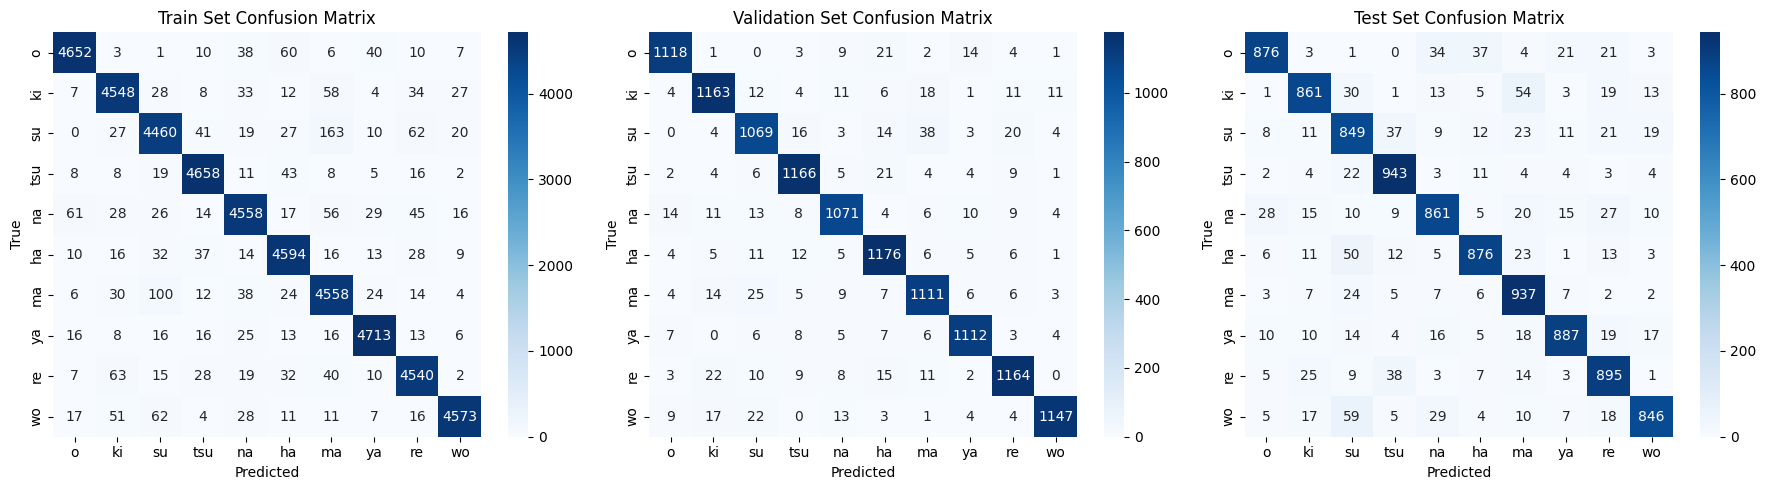

In [26]:
plot_confusion_matrices(predictions_model_1, class_names=full_train.classes)

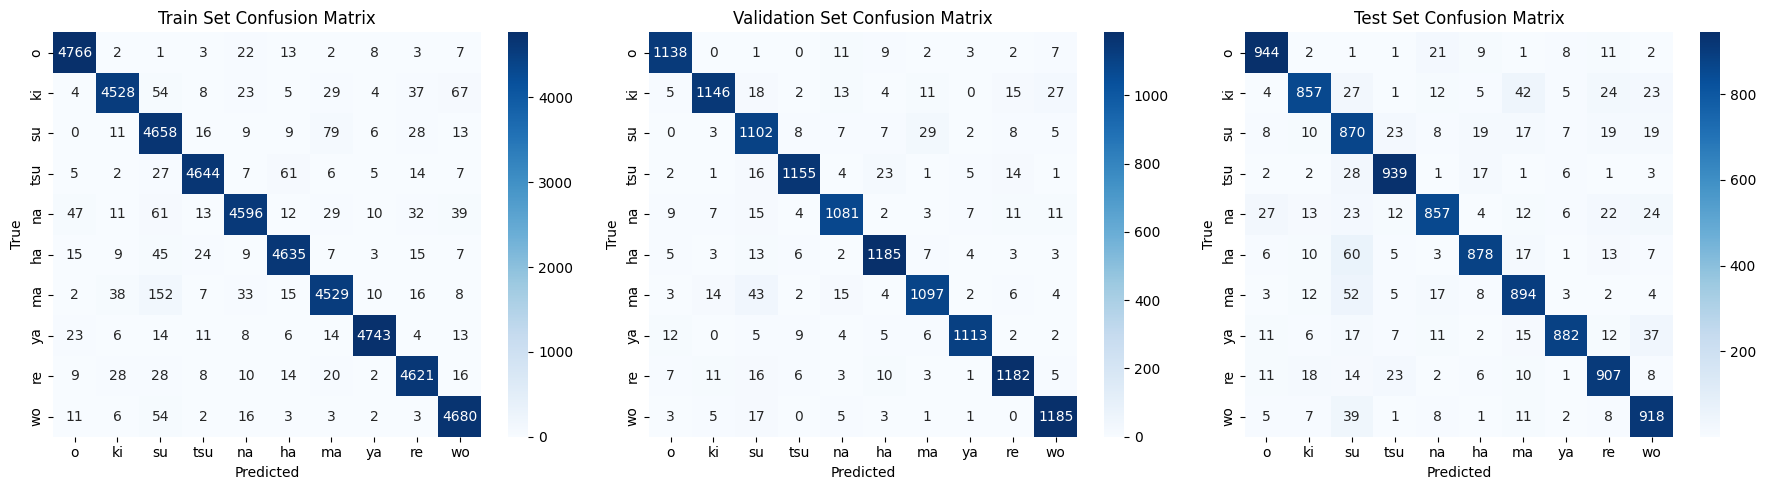

In [27]:
plot_confusion_matrices(predictions_model_2, class_names=full_train.classes)

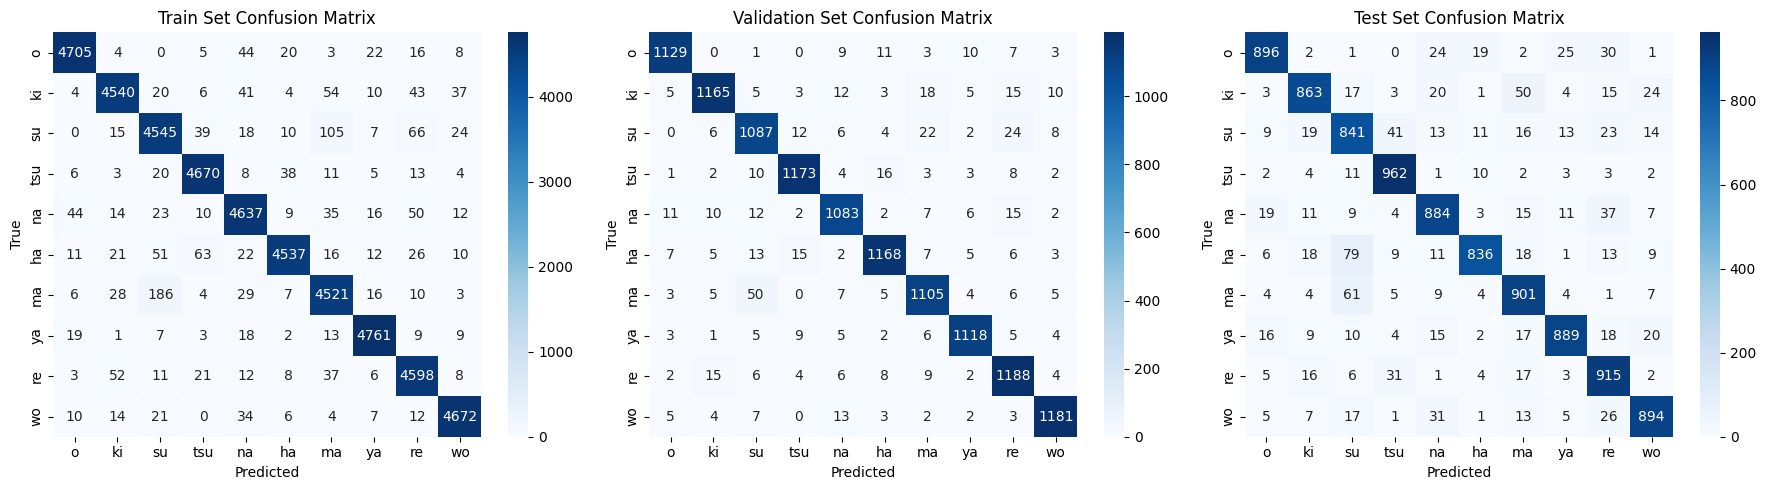

In [28]:
plot_confusion_matrices(predictions_model_3, class_names=full_train.classes)

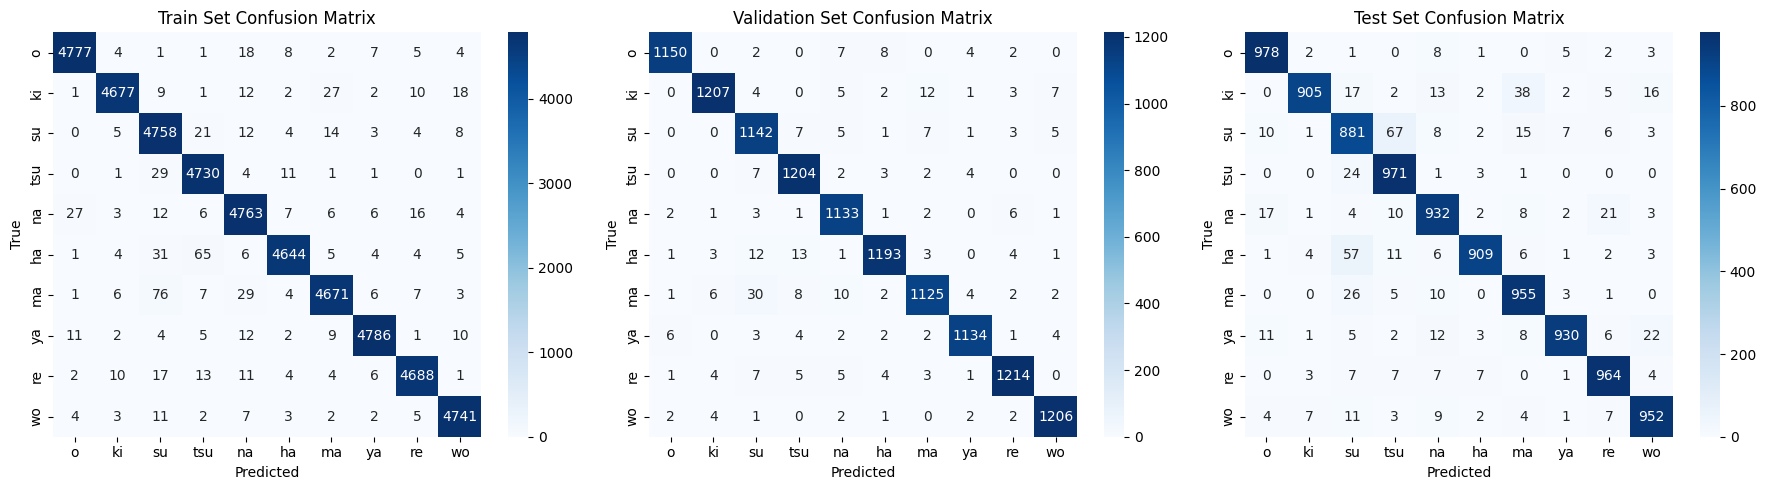

In [29]:
plot_confusion_matrices(CNN2_model_1_predictions, class_names=full_train.classes)

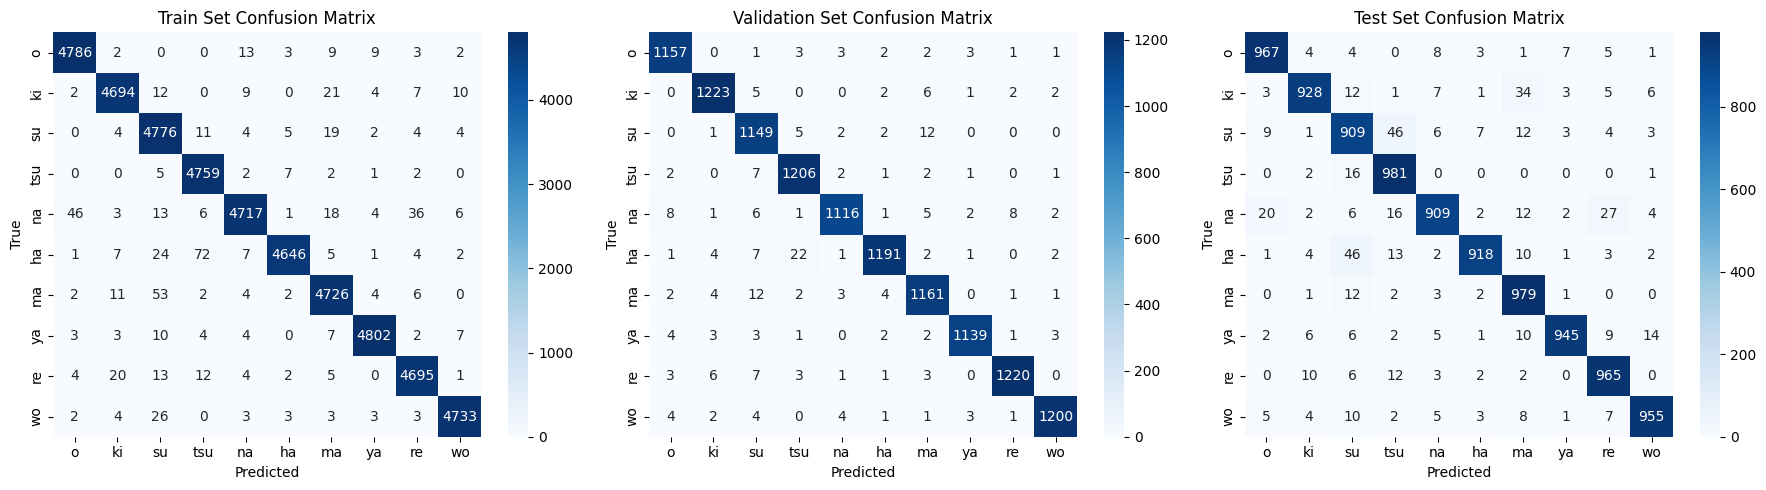

In [30]:
plot_confusion_matrices(CNN2_model_2_predictions, class_names=full_train.classes)

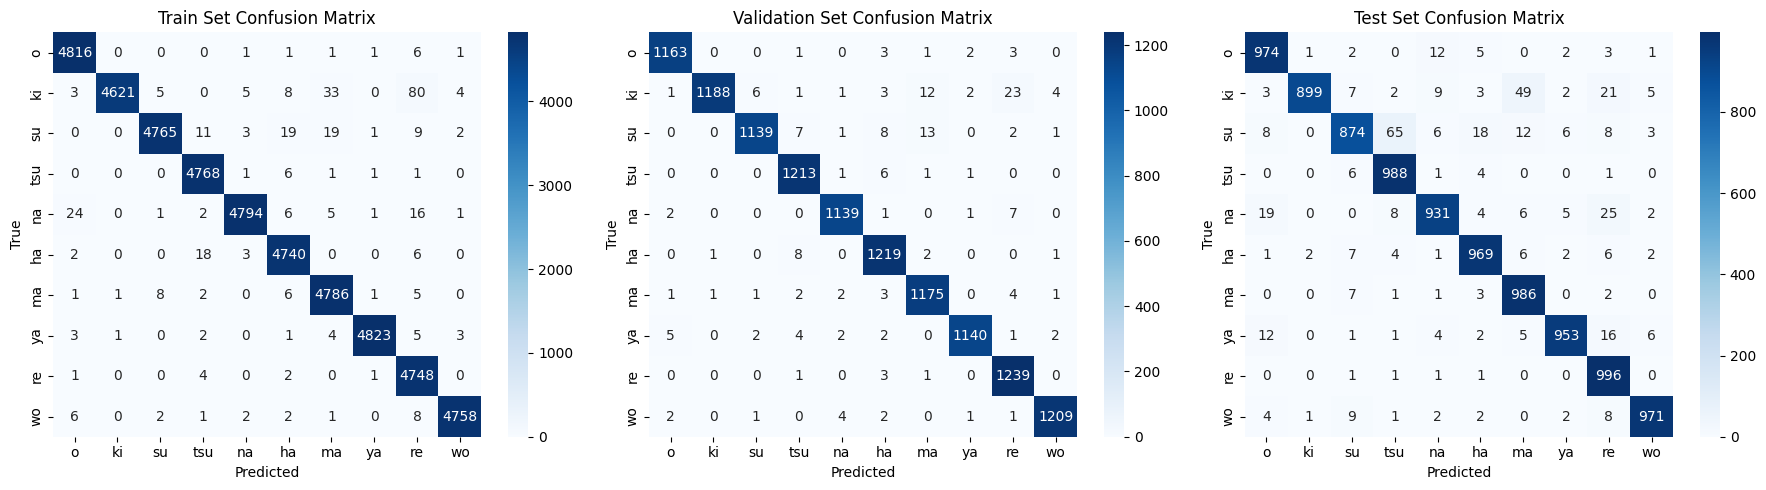

In [31]:
plot_confusion_matrices(CNN3_model_4_predictions, class_names=full_train.classes)

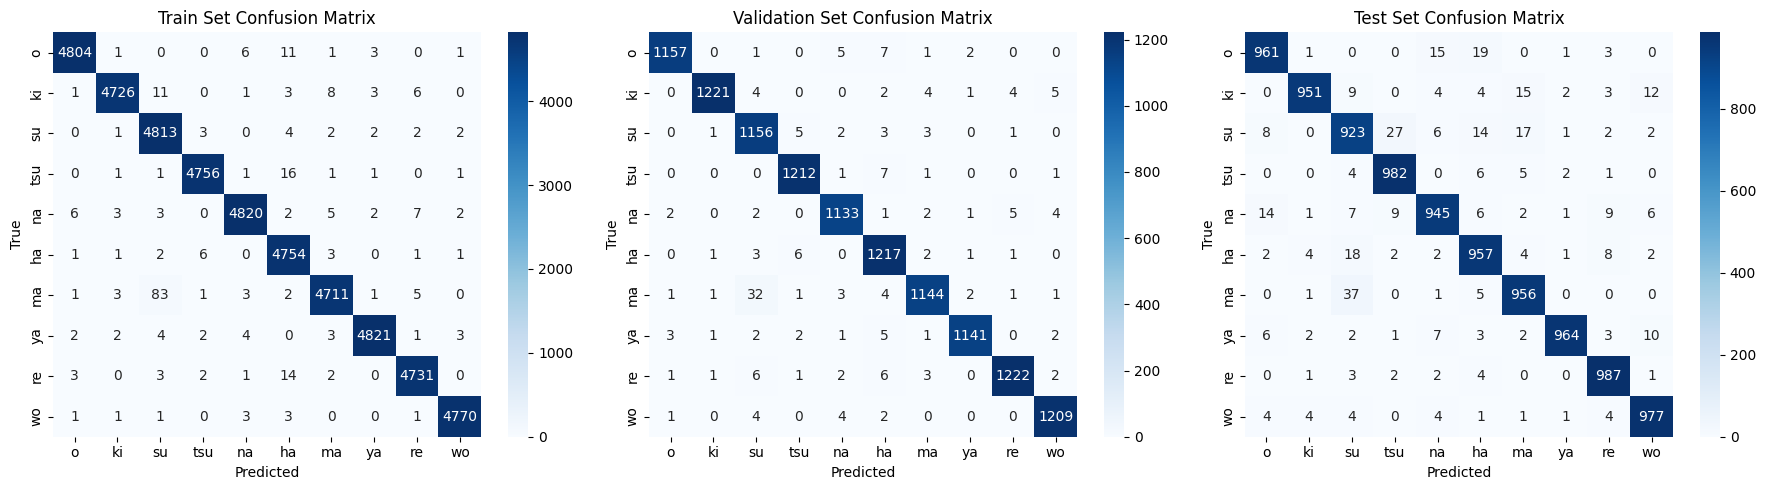

In [32]:
plot_confusion_matrices(CNN3_model_5_predictions, class_names=full_train.classes)

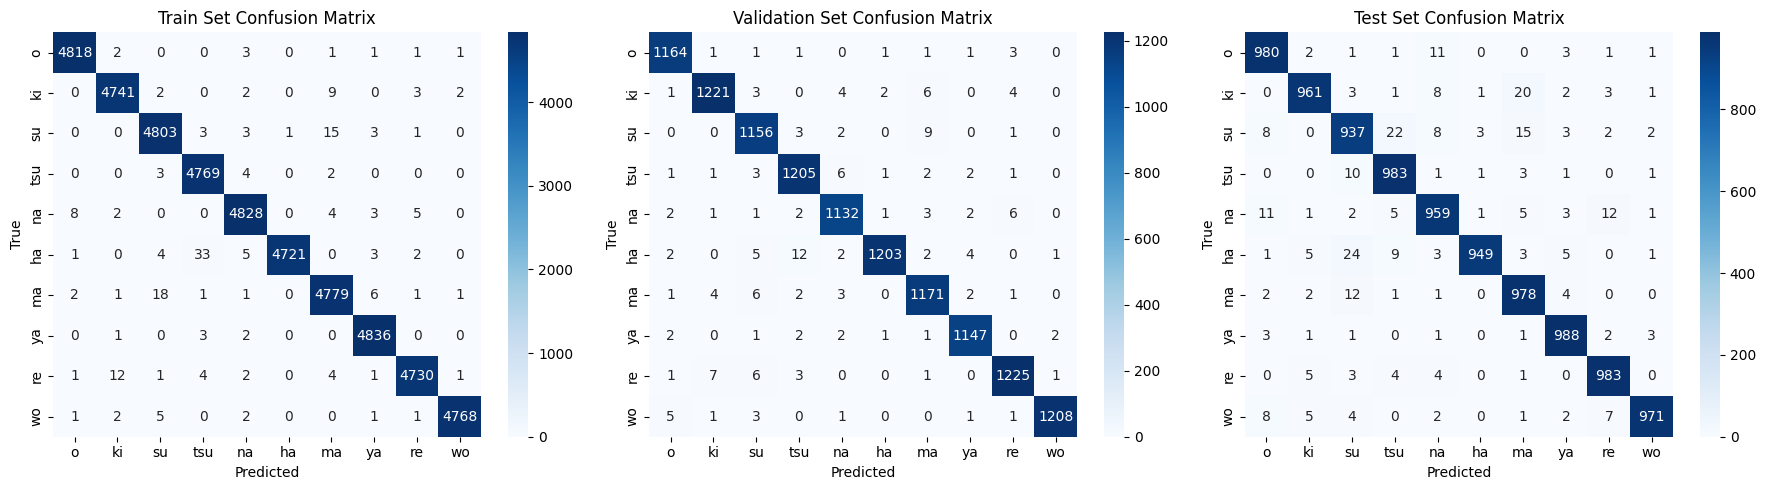

In [33]:
plot_confusion_matrices(CNN3_model_6_predictions, class_names=full_train.classes)

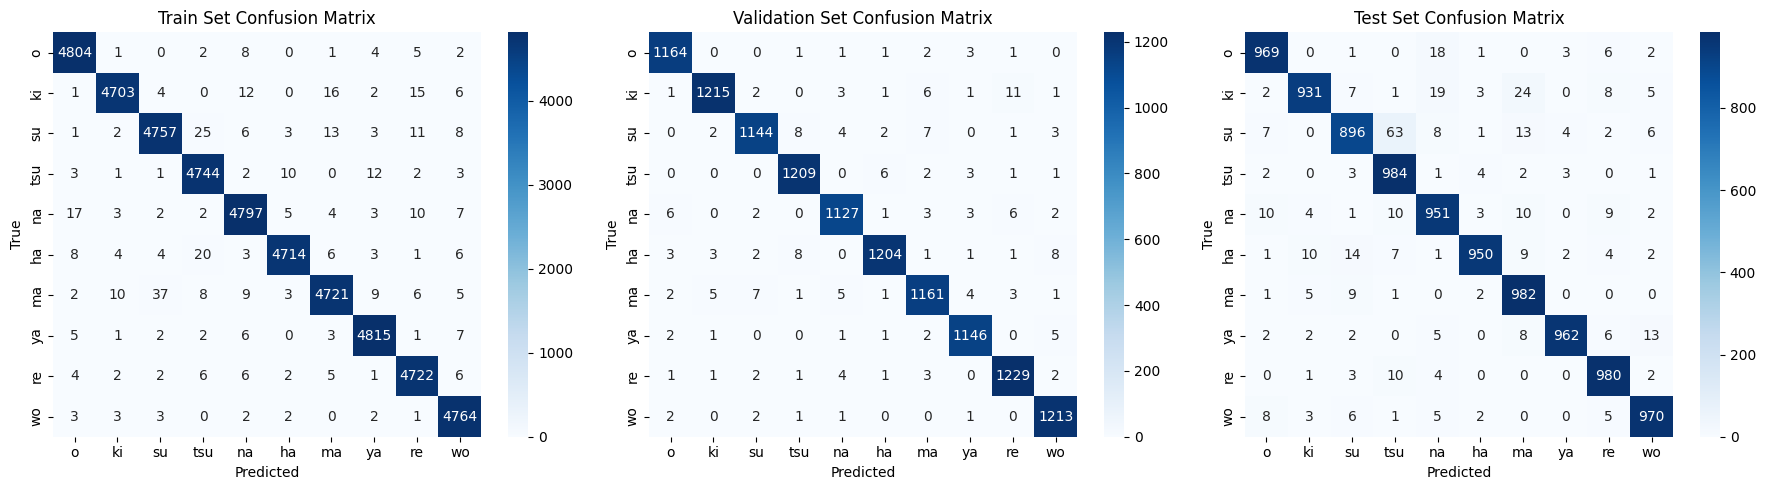

In [34]:
plot_confusion_matrices(CNN3_model_7_predictions, class_names=full_train.classes)